# Project - DNN1 - Classification Problem

## Imports

In [1]:
from torch import nn, optim
import torch as t
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import (InterpolationMode, ToTensor, GaussianBlur, Resize, RandomApply,
                                    RandomAutocontrast, RandomAdjustSharpness, 
                                    RandomPosterize, RandomRotation, RandomEqualize, 
                                    ColorJitter, CenterCrop, Pad, RandomAffine, RandomVerticalFlip, RandomHorizontalFlip)
from torchvision import io
from torchvision.models import resnet18
import gc
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from typing import Tuple, Dict, List, Union, Optional, Any, Callable, Type
from collections import defaultdict, OrderedDict
from dataclasses import dataclass, fields, _MISSING_TYPE
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes

from os import walk, path, makedirs

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

PROJECT_PRIME_SEED = 2137

In [2]:
t.manual_seed(PROJECT_PRIME_SEED)

## Plant dataset

- I've collected and manually preprocessed about 400 images for training project purpose.
- Pictures show 6-plant classes: Phalaenopsis, Warczewiczella, Philodendron, Ficus, Aloe and Macodes.
- I chose plants intentionally - apart from Macodes, I own each of genus specimens, therefore I can validate trained model on real representatives. I've taken 58 pictures. The missing macodes genus is represented by pilea 'Moon Walley' https://en.wikipedia.org/wiki/Pilea_mollis, since noticeable purple veins could resemble the structure of macodes leaves.

### The structure of dataset:
- Each sample belonging to a specified class is in the class directory.
- Each sample can be marked as a test or training one (appropriate directory is an indicator).

In [3]:
class PlantDataset(Dataset):
	csv_cols = ['Key', 'Full Name', 'Label']
	delimiter: str =';'
 
	def __init__(self, assets_dir: str, train: Optional[bool] =None, transform=ToTensor(), target_transform =None, classes_mapping_file: str =None) -> None:
		super().__init__()
		self.target_dir = "train" if train is not None and train else "test" if train is not None and not train else ""
		self.root = path.join(assets_dir, self.target_dir)
		self.__str_labels: List[str] = next(walk(self.root))[1]

		self._transform = transform
		self._target_transform = target_transform
		_mapping: Union[pd.DataFrame, None] = None if not classes_mapping_file else pd.read_csv(classes_mapping_file, delimiter=PlantDataset.delimiter, names=PlantDataset.csv_cols)
		self.__mapping = _mapping
		self._lazy_load = True
		self.__class_files = [(_class, file) for _class in self.__str_labels for file in next(walk(path.join(self.root, _class)))[2]]
		self.__labels = [self.__map(cls) for cls, _ in self.__class_files]
		if len(self.__class_files) < 8*1e3: 
			self._lazy_load = False
			self.__samples = [self.__load_sample(idx) for idx in range(len(self))];print("loaded")
            
	@property
	def mapping(self): return self.__mapping
    
	def __map(self, cls):
		return self.__str_labels.index(cls) if self.__mapping is None else self.__mapping[self.__mapping['Key'] == cls]['Label'].item()
    
	def __load_sample(self, index):
		_class, file = self.__class_files[index]
		img_path = path.join(self.root, _class, file)
		image = io.read_image(img_path)
		label = self.labels[index]
		return image, label
    
	def __getitem__(self, index):
		image, label = self.__load_sample(index) if self._lazy_load else self.__samples[index]
  
		if self._transform and type(self._transform) is not ToTensor: image = self._transform(image)

		if self._target_transform: label = self._target_transform(label)
	
		return image, label
    
	@property    
	def labels(self): return (self.__labels)

	def __len__(self): return len(self.__labels)

In [4]:
dataset = PlantDataset('dataset', train=None, transform=Resize((256,256)), classes_mapping_file="mapping.csv")

loaded


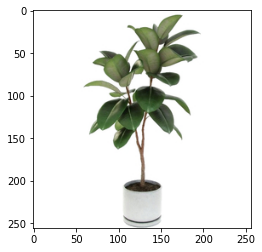

In [5]:
image, label = dataset[100]
plt.imshow(image.permute(1,2,0))

In [6]:
len(dataset)

474

### Splitting dataset with stratification

In [7]:
def split_with_stratification(dataset: Dataset, ratio: float=0.9):

	labels = []
	if hasattr(dataset, 'labels'):
		labels = dataset.labels
	elif hasattr(dataset, 'targets'):
		labels = dataset.targets
	else:
		loader = DataLoader(dataset, batch_size=32)
		for _, y in loader: labels += y.tolist() 
	            
	linspace = list(range(len(dataset)))
	
	train_indices, test_indices = train_test_split(linspace, train_size=ratio, test_size=1-ratio, stratify=labels)
	
	return Subset(dataset, train_indices), Subset(dataset, test_indices)

In [8]:
subsets = split_with_stratification(dataset)
[len(subset) for subset in subsets]

[426, 48]

## Helper augmentations

In [9]:
class RandomPaddedRotation(RandomRotation):
	def __init__(self, degrees, interpolation=InterpolationMode.NEAREST, expand=False, fill=0, padding_mode='reflect', resample=None):
		super().__init__(degrees, interpolation, expand, None, fill, resample)
		self.padding_mode = padding_mode

	def forward(self, img):
		padded = Pad(((img.shape[-2])//2, (img.shape[-1])//2), padding_mode=self.padding_mode, fill=self.fill).forward(img)
		rotated = super().forward(padded)
		return CenterCrop(img.shape[-2:]).forward(rotated)


In [10]:
class RandomPaddedAffine(RandomAffine):
	def __init__(self, translate=None, scale=None, shear=None, fill=0, padding_mode='reflect', interpolation=InterpolationMode.NEAREST):
		super().__init__(0, translate, scale, shear, interpolation, fill=fill)
		self.padding_mode = padding_mode
		
	def forward(self, img):
		padded = Pad((int((img.shape[-2])-2), int((img.shape[-1]))-2), padding_mode=self.padding_mode, fill=self.fill).forward(img)
		affined = super().forward(padded)
		return CenterCrop(img.shape[-2:]).forward(affined)


In [11]:
rotator = RandomPaddedRotation((-45, 45), expand=True)

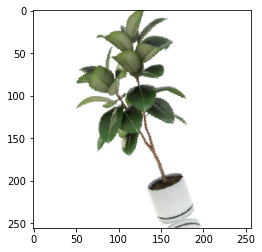

In [12]:
aug_1 = (rotator(image))
plt.imshow(aug_1.permute(1,2,0))

In [13]:
affiner = RandomPaddedAffine((0.05, 0.05), (0.8, 1.1), (-20, 20))

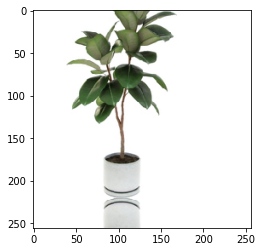

In [14]:
aug_1 = (affiner(image))
plt.imshow(aug_1.permute(1,2,0))

## Dataset Augmentation

- I've prepared a feature-rich module for data-augmentation.
- It can save augmented images on disk or preprocess them on the fly.
- There is an opportunity to turn on/off the augmentation operator and provide specified options to initialize each preprocessor.

In [15]:

@dataclass
class AugmentatorOptions:
	angles: Union[Tuple[Union[float, int], Union[float, int]], int, float] =45
	interpolation: InterpolationMode =InterpolationMode.NEAREST	
	expand: bool =False
	brightness: Union[Tuple[Union[float, int], Union[float, int]], int, float] =0
	contrast: Union[Tuple[Union[float, int], Union[float, int]], int, float] =0
	hue: Union[Tuple[Union[float, int], Union[float, int]], int, float] =0
	saturation: Union[Tuple[Union[float, int], Union[float, int]], int, float] =0
	shear: Union[Tuple[Union[float, int], Union[float, int]], int, float] =45
	scale:Tuple[Union[float, int], Union[float, int]] =(0.8,1.01)
	translate: Tuple[Union[float, int], Union[float, int]] =(0.01, 0.01)
	bits: int =8
	sharpness_factor: float =1
	sigma: Union[Tuple[float, float], float] =0.5
	kernel_size: Tuple[int, int] =(3, 3)
	target_shape: Tuple[int, int] =(256, 256)	
	antialias: Optional[bool] =None
	padding_mode: str ="reflect"
	fill: Union[List[Union[float, int]], int, float] =0
	expand: bool =True
 
	p_scale_shear_and_translate: float =0.5
	p_auto_contrast: float =0.5
	p_equalize: float =0.5
	p_sharpen: float =0.5
	p_posterize: float =0.5
	p_blur: float =0.5
	p_rotate: float =0.5
	p_color_jitter: float =0.5
	p_horizontal_flip: float =0.5
	p_vertical_flip: float =0.5
 
	def __post_init__(self):
	    for field in fields(self):
	  	    if not isinstance(field.default, _MISSING_TYPE) and getattr(self, field.name) is None:
		   	    setattr(self, field.name, field.default)

In [16]:
class ImageDataAugmentator(nn.Module):
	def __init__(self, rotate=True, color_jitter=False, adjust_sharpeness=False,
			  	 blur=False, posterize=False, autoconstrast=False, equalize=False,
				 shear_scale_and_translate=False, disable_hue_and_saturation=False,
				 horizontal_flip=False, vertical_flip=False,
				 options: AugmentatorOptions= AugmentatorOptions()) -> None:
		super().__init__()
  
		modules: List[nn.Module] =[]
		if rotate: modules.append(RandomApply([RandomPaddedRotation(options.angles, options.interpolation, options.expand, 
                                                              options.fill, options.padding_mode)], options.p_rotate))
		if color_jitter: 
			jitter = ColorJitter(options.brightness, options.contrast, options.saturation, options.hue)
			if disable_hue_and_saturation:
				jitter.hue = None
				jitter.saturation = None
			modules.append(RandomApply( [jitter], options.p_color_jitter))
		if adjust_sharpeness: modules.append(RandomAdjustSharpness(options.sharpness_factor, options.p_sharpen))
		if blur: modules.append(RandomApply[GaussianBlur(options.kernel_size, options.sigma)], options.p_blur)
		if posterize: modules.append(RandomPosterize(options.bits, options.p_posterize))
		if autoconstrast: modules.append(RandomAutocontrast(options.p_auto_contrast))
		if equalize: modules.append(RandomEqualize(options.p_equalize))
		if shear_scale_and_translate: modules.append(RandomApply([RandomPaddedAffine(options.translate, options.scale, options.shear, 
                                                                               options.fill, options.padding_mode, options.interpolation)], options.p_scale_shear_and_translate))
		if horizontal_flip: modules.append(RandomHorizontalFlip(options.p_horizontal_flip))
		if vertical_flip: modules.append(RandomVerticalFlip(options.p_vertical_flip))
		self.resize = (Resize(size=options.target_shape, interpolation=options.interpolation, antialias=options.antialias))
		
		self.__processors = nn.Sequential(
			*modules
		)
  
	def forward(self, x): return  self.resize(self.__processors(x)) if self.training else self.resize(x)
	
	def __yielder(self, data: Dataset, batch_size=1):
		return DataLoader(data, batch_size)
 
	def augment(self, data: Union[Dataset, DataLoader], label_mapper: Union[pd.DataFrame, List[str], Dict[Any, str]] = None, 
			 	df_label_col = "Label", df_name_col = "Name", epochs = 1000, directory = 'augmented', train: Optional[bool] =True, jpg=False, batch_size=1):
	 
		if isinstance(data, Dataset):
			data = self.__yielder(data, batch_size)

		target_dir = "train" if train is not None and train else "test" if train is not None and not train else ""
		writer = (io.write_jpeg if jpg else io.write_png)
		writer_kw = {"quality":100} if jpg else {"compression_level":8}
		ext = "jpg" if jpg else "png"
		samples_for_class = defaultdict(lambda: 0)
  
		if isinstance(data, DataLoader):
			loop = tqdm(range(epochs), desc='Epoch', unit='epoch')
			for epoch in loop:
				id_for_class = defaultdict(lambda: 0)
				for img, y in data:
					augmented: t.Tensor = self.forward(img.to("cuda")).to('cpu')

					if hasattr(y, 'ndim'): y=y.tolist()
					
					for i in range(len(y)):
						label = y[i]
						if isinstance(label_mapper, pd.DataFrame):
							name = label_mapper[label_mapper[df_label_col] == label][df_name_col].item()	
						elif isinstance(label_mapper, dict):
							name = label_mapper.get(label, f"class_{label}")
						elif isinstance(label_mapper, list):
							name = label_mapper[label]
						else:
							name = f"class_{label}"
						id_for_class[name] += 1
						if not epoch:
							samples_for_class[name] += 1
						_path = path.join(directory, target_dir, name)
	
						if not path.isdir(_path): makedirs(_path, 0o777, True)
						writer(augmented[i], path.join(_path, f"{name}_{id_for_class[name]-1 + samples_for_class[name]* epoch}.{ext}"), **writer_kw)

In [17]:
augmentator = ImageDataAugmentator(autoconstrast=True, 
                                   adjust_sharpeness=True, 
                                   shear_scale_and_translate=True,
                                   vertical_flip=True, 
                                   horizontal_flip=True,
                                   options=AugmentatorOptions(angles=(-30, 30),
                                                              interpolation=InterpolationMode.NEAREST,
                                                              target_shape=(256,256),
                                                              translate=(0.03, 0.03), 
                                                              scale=(0.9, 1.1),
                                                              sharpness_factor=1.2, 
                                                              shear=(-15, 15), 
                                                              p_vertical_flip=0.8, 
                                                              p_horizontal_flip=0.8,
                                                              p_rotate=0.98,
                                                              p_scale_shear_and_translate=0.95,
                                                              padding_mode='reflect', 
                                                              fill=0)).to('cuda')

In [18]:
dataset = PlantDataset('dataset',
                       train=None, 
                       transform=Resize((256,256)), 
                       classes_mapping_file="mapping.csv")

loaded


In [20]:
augmentator.augment(DataLoader(dataset, 32),
                    dataset.mapping,
                    train=None,
                    df_name_col="Key",
                    epochs=100, 
                    jpg=True, 
                    directory="augmented")

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]

In [19]:
del dataset

gc.collect()

0

## Residual Learning Network

- For feature extraction I've chosen a ResNet architecture described thoroughly here: https://arxiv.org/pdf/1512.03385v1.pdf

In [20]:
class Lambda(nn.Module):
	def __init__(self, _lambda) -> None:
		super().__init__()
		self.__lambda = _lambda
	def forward(self, x): return self.__lambda(x) 

In [21]:
class Conv2dAutoPad(nn.Conv2d):
	def __init__(self, in_channels: int,
				 out_channels: int,
				 kernel_size: Union[int,Tuple[int, int]], 
			  	 stride:Union[int,Tuple[int, int]] =1,
				 dilation: Union[int,Tuple[int, int]] =1, 
				 groups: int =1,
				 bias: bool =True,
				 device=None,
				 dtype=None) -> None:
	 
		super().__init__(in_channels,
						 out_channels,
						 kernel_size,
						 stride,
						 dilation=dilation,
						 groups=groups,
						 bias=bias,
						 device=device,
						 dtype=dtype)
  
		self.padding = (0,0)
		self.auto_padding = sum(list(map(lambda x: (x//2, max(x//2 - 1 + (x&1), 0)), self.kernel_size[::-1])), ())
  
	def forward(self, X: t.Tensor):
		padded = F.pad(X, self.auto_padding)
		return super().forward(padded)

In [22]:
Conv2dAutoPad(8, 16, 3, stride=2)

Conv2dAutoPad(8, 16, kernel_size=(3, 3), stride=(2, 2))

In [23]:
class MaxPool2dAutoPad(nn.MaxPool2d):
	def __init__(self, kernel_size:  
				 Union[int,Tuple[int, int]],
				 stride: Union[int,Tuple[int, int]] = None,
			  	 dilation: Union[int,Tuple[int, int]] = 1,
				 return_indices: bool = False) -> None:
			
		super().__init__(kernel_size, 
						 stride,
						 dilation=dilation,
						 return_indices=return_indices,
						 ceil_mode=True)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1, 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor):
		x, y = X.shape[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

In [24]:
class Activations:
	_modules: Dict[str, Callable[[],nn.Module]] = {
		'relu': lambda: nn.ReLU(),
		'prelu-1':lambda: nn.PReLU(),
		'prelu-3':lambda: nn.PReLU(3),
		'prelu-8':lambda: nn.PReLU(8),
		'prelu-16':lambda: nn.PReLU(16),
		'prelu-32':lambda: nn.PReLU(32),
		'prelu-64':lambda: nn.PReLU(64),
		'prelu-128':lambda: nn.PReLU(128),
		'prelu-256':lambda: nn.PReLU(256),
		'prelu-512':lambda: nn.PReLU(512),
		'prelu-1024':lambda: nn.PReLU(1024),
		'leaky-relu':lambda: nn.LeakyReLU(),
		'tanh':lambda: nn.Tanh(),
		'selu':lambda: nn.SELU(),
		'sigmoid':lambda: nn.Sigmoid()
	}
 
	@classmethod
	def get(cls, activation): return Activations._modules.get(activation, lambda: nn.Identity())()
	

In [25]:
ctor = Activations.get('relu')

In [26]:
ctor is Activations.get('relu')

False

In [27]:
def to_2dim(item: Union[int, Tuple[int, int]]) -> Tuple[int, int]: 
    return (item, item) if isinstance(item, int) else tuple(item)

In [28]:
class Block(nn.Module):
	_block: nn.Module
    
	def __init__(self, in_channels: int,
                 out_channels: int,
                 bias: bool =True, 
              	 activation: str ='relu',
                 groups: int =1, 
                 device=None, 
                 dtype=None) -> None:
		super().__init__()
		self.in_channels = in_channels
		self.out_channels = out_channels
		self.bias = bias
		self.groups = groups
		self.activation_name = activation
		self.dtype=dtype
		self.device = device
  
	@property
	def block(self): return self._block
 
	def forward(self, x): return self.block(x)
	
	def _post_init_(self): pass

In [29]:
class ResidualBlock(Block):
	
	_shortcut: nn.Module
 
	def __init__(self, in_channels: int,
                 out_channels: int, 
                 stride: Union[int,Tuple[int, int]] =1, 
              	 projection: int =1,
                 activation: str ='relu',
                 groups: int =1,
                 device=None,
                 dtype=None) -> None:
     
		super().__init__(in_channels, out_channels, False, activation, groups, device, dtype)
  
		self.projection = projection
		self.stride = to_2dim(stride)

  
	def _post_init_(self):
		self._shortcut = nn.Identity() if not self.downsampling_shortcut else nn.Sequential(
			Conv2dAutoPad(self.in_channels,
                          self.out_channels * self.projection, 
                          1, self.stride,
                          bias=self.bias,
                          groups=self.groups,
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels * self.projection)
		)
		
		return super()._post_init_()
	@property
	def downsampling_shortcut(self): return [
        factor for factor in self.stride if factor > 1
    ] or self.in_channels != (self.out_channels * self.projection)
  
	@property
	def shortcut(self): return self._shortcut
  
	def forward(self, x):
		b_x = super().forward(x)
		identity = self.shortcut(x)
		return (b_x + identity)

In [30]:
class BasicBlock(ResidualBlock):
	def __init__(self, in_channels: int, 
                 out_channels: int, 
                 stride: Union[int, Tuple[int, int]] =1,
                 kernel_size: Union[int, Tuple[int, int]] =3,
              	 activation: str ='relu', 
                 groups: int =1, 
                 device=None, 
                 dtype=None) -> None:
     
		super().__init__(in_channels, out_channels, stride, 1, activation, groups, device, dtype)
		self.kernel_size = to_2dim(kernel_size)
		self._block = nn.Sequential(
			Conv2dAutoPad(self.in_channels,
                          self.out_channels, 
                          self.kernel_size, 
                          self.stride, 
                 		  bias=self.bias, 
                          groups=self.groups, 
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels),
			Activations.get(self.activation_name),
			Conv2dAutoPad(self.out_channels,
                          self.out_channels,
                          self.kernel_size, 1, 
                 		  bias=self.bias,
                          groups=self.groups,
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels)
		)
  
		self._post_init_()
  
	def _post_init_(self):
		return super()._post_init_()

In [31]:
class BottleneckBlock(ResidualBlock):
	def __init__(self, in_channels: int,
                 out_channels: int, 
                 stride: Union[int, Tuple[int, int]] =1, 
                 kernel_size: Union[int, Tuple[int, int]] =3,
                 activation: str ='relu', 
                 groups: int =1, 
                 device=None, 
                 dtype=None) -> None:
	 
		super().__init__(in_channels, out_channels, stride, 4, activation, groups, device, dtype)
		self.kernel_size = to_2dim(kernel_size)
		self._block = nn.Sequential(
			Conv2dAutoPad(self.in_channels,
                          self.out_channels,
                          1, self.stride, 
				 		  bias=self.bias,
                          groups=self.groups,
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels),
			Activations.get(self.activation_name),
			Conv2dAutoPad(self.out_channels,
                          self.out_channels,
                          self.kernel_size, 1, 
				 		  bias=self.bias,
                          groups=self.groups,
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels),
			Activations.get(self.activation_name),
			Conv2dAutoPad(self.out_channels,
                          self.out_channels * self.projection,
                          1, 1, bias=self.bias,
                          groups=self.groups,
                          device=self.device,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels * self.projection)
		)
		self._post_init_()
  
	def _post_init_(self):
		return super()._post_init_()

In [32]:
class GateBlock(Block):
	def __init__(self, in_channels: int,
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] =7,
                 pooling_kernel_size: Union[int, Tuple[int, int]] =3, 
            	 stride: Union[int, Tuple[int, int]] =2,
                 activation: str ='relu',
                 groups: int =1,
                 device=None,
                 dtype=None) -> None:
		super().__init__(in_channels, out_channels, False, activation, groups, device, dtype)
  
		self.pooling_kernel_size = to_2dim(pooling_kernel_size)
		self.stride = to_2dim(stride)
		self.kernel_size = to_2dim(kernel_size)
  
		self._block = nn.Sequential(
			Conv2dAutoPad(self.in_channels,
                          self.out_channels,
                          self.kernel_size,
                          self.stride, 
                          bias=self.bias,
                          device=self.device,
                          groups=self.groups,
                          dtype=self.dtype),
			nn.BatchNorm2d(self.out_channels),
			Activations.get(self.activation_name),
			MaxPool2dAutoPad(self.pooling_kernel_size, self.stride)
		)

In [33]:
class ResNetBaseLayer(Block):
	def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int, Tuple[int, int]],
                 block: Type[Union[BasicBlock, BottleneckBlock]],
              	 n_blocks: int =1, 
                 stride: Union[int, Tuple[int, int]] =2,
                 activation: str ='relu',
                 groups: int =1,
                 device=None,
                 dtype=None) -> None:
		super().__init__(in_channels, out_channels, False, activation, groups, device, dtype)
		
		self.stride = to_2dim(stride)
		self.n_blocks = n_blocks
		self.kernel_size = to_2dim(kernel_size)
		_block_ctor = partial(block, 
                              kernel_size=self.kernel_size,
                              activation=self.activation_name, 
                              groups=self.groups, 
                              device=self.device, 
                              dtype=self.dtype)
        
		downsampling_block = _block_ctor(self.in_channels,
                                         self.out_channels, 
                                         self.stride)
        
		projected = downsampling_block.projection * self.out_channels

		self._projection = downsampling_block.projection

		self._block = nn.Sequential(
			downsampling_block,
			*[_block_ctor(projected, self.out_channels, 1) for _ in range(self.n_blocks - 1)]   
		)
  
	@property
	def projection(self): return self._projection

In [34]:
class ResNetBaseEncoder(Block):
	def __init__(self, in_channels: int, 
                 block_channels: List[int], 
                 blocks: List[int], 
                 kernels: List[Union[int, Tuple[int, int]]],
              	 block_types: Union[Type[Union[BasicBlock, BottleneckBlock]],
                                    List[Type[Union[BasicBlock, BottleneckBlock]]]], 
				 strides: Union[Union[int, Tuple[int, int]], List[Union[int, Tuple[int, int]]]] =2,
                 pooling_kernel_size: Union[int, Tuple[int, int]] =3,  
     			 activation: str ='relu', 
                 groups: int =1, 
                 device=None, 
                 dtype=None) -> None:
     
		assert len(kernels) == len(block_channels) + 1 and len(blocks) == len(block_channels)
		
		if isinstance(block_types, list) and len(block_types) != len(block_channels): 
			raise Exception(f"Invalid dimensions of block type list: got {len(block_types)}, expected {len(block_channels)}")
		elif not isinstance(block_types, list): block_types = [block_types] * len(block_channels)
  
		if isinstance(strides, list) and len(strides) != len(kernels): 
			raise Exception(f"Invalid dimensions of stride list: got {len(strides)}, expected {len(kernels)}")
		elif not isinstance(strides, list): strides = [strides] * len(kernels)
  
		super().__init__(in_channels, block_channels[-1], False, activation, groups, device, dtype)
		
		kwargs = dict(activation=self.activation_name, 
                      groups=self.groups, 
                      device=self.device, 
                      dtype=self.dtype)
		
		layers = []
  
		if blocks:
			layer = ResNetBaseLayer(block_channels[0], 
                                    block_channels[0], 
                                    kernels[1], 
                                    block_types[0], 
                                    blocks[0], 
                                    strides[1], 
                                    **kwargs)
			layers.append(layer)
   
			for i in range(1, len(blocks)):
				layer = ResNetBaseLayer(block_channels[i - 1] * layer.projection, 
                                        block_channels[i], 
                                        kernels[i + 1],
                                        block_types[i], 
                                        blocks[i], 
                                        strides[i + 1], 
                                        **kwargs)	
				layers.append(layer)
    
			self.out_channels *= layer.projection

		self._block = nn.Sequential(
			GateBlock(in_channels, 
                      block_channels[0], 
                      kernels[0], 
                      pooling_kernel_size, 
                      strides[0], 
                      **kwargs),
			*layers
		)

In [35]:
class ResNetBaseDecoder(Block):
	def __init__(self, in_channels: int, out_channels: int, device=None, dtype=None) -> None:
		super().__init__(in_channels, out_channels, True, device=device, dtype=dtype)

		self._block = nn.Sequential(
			nn.AdaptiveAvgPool2d((1, 1)),
			nn.Flatten(1),
			nn.Linear(in_channels, out_channels, self.bias, self.device, self.dtype)
		)

In [36]:
class ResNet(nn.Module):
	def __init__(self, in_channels: int,
                 out_channels: int, 
                 block_channels: List[int], 
                 blocks: List[int], 
                 kernels: List[Union[int, Tuple[int, int]]],
			  	 block_types: Union[Type[Union[BasicBlock, BottleneckBlock]], 
                                    List[Type[Union[BasicBlock, BottleneckBlock]]]], 
				 strides: Union[Union[int, Tuple[int, int]], List[Union[int, Tuple[int, int]]]] =2,
                 pooling_kernel_size: Union[int, Tuple[int, int]] =3,  
	 			 activation: str ='relu', 
                 groups: int =1, 
                 device=None, 
                 dtype=None) -> None:
		super().__init__()

		self._encoder = ResNetBaseEncoder(in_channels, 
                                          block_channels, 
                                          blocks, 
                                          kernels, 
                                          block_types, 
                                          strides, 
										  pooling_kernel_size,
                                          activation, 
                                          groups, 
                                          device, 
                                          dtype)
		self._decoder = ResNetBaseDecoder(self._encoder.out_channels,
                                          out_channels,
                                          device,
                                          dtype)

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
			elif isinstance(m, nn.Linear):
				nn.init.constant_(m.bias, 0)
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
	
	def forward(self, x):
		x = self._encoder(x)
		return self._decoder(x)

## Training utilities

In [37]:
def update_loop(loop: tqdm, metrics: Dict[str, float]):
	loop.set_postfix(metrics)
	return tuple(metrics.values())

In [38]:
def fit(model: nn.Module, loss: nn.Module, optimizer: optim.Optimizer, train_data: Dataset, 
		epochs=1, batch_size=32, validation_batch_size=32, validation_data:Dataset=None, 
		model_to_save: nn.Module=None, name: str="model", 
        save_model_on_metrics: List[str]=['Loss','Accuracy']):
    
	assert batch_size > 0 and epochs > 1
	import string
	remove_punctuation = str.maketrans(string.punctuation, '_'*len(string.punctuation))
	device = "cuda" if t.cuda.is_available() else "cpu"
		
	loop = tqdm(range(epochs), position=0)
 
	training_data_loader =DataLoader(train_data, batch_size, shuffle=True)
  
	evaluate = validation_data is not None
	test_data_loader = DataLoader(validation_data, 
                                  validation_batch_size, 
                                  shuffle=True) if evaluate else None
 
	basic_metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
	metrics = OrderedDict({metric:(0.0 if 'Loss' not in metric else np.inf) for metric in basic_metrics})
 
	if evaluate:
		metrics = {**metrics, **{f"Eval. {key}":value for key, value in metrics.items()}}	
  
	if any([observable for observable in save_model_on_metrics if observable not in metrics]): 
		raise Exception(f"Not all provided metric can be computed, supported: {list(metrics.keys())}")
   
	model = model.to(device)
 
	if model_to_save is None: model_to_save = model
 
	def __turn_on_off_running_stats(model: nn.Module, on=True):
		for m in model.modules():
			if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
				m.track_running_stats = on
    
	best_metrics = {metric:(0.0 if 'Loss' not in metric else np.inf) for metric in save_model_on_metrics}
	comp_metrics = {metric:(lambda old, new: old < new) if 'Loss' not in metric else (
        lambda old, new: old > new) for metric in save_model_on_metrics}
	short_metrics = {metric: metric.translate(remove_punctuation)
                     .replace('_', '')
                     .replace(' ', '_') for metric in save_model_on_metrics}
	#__turn_on_off_running_stats(model, False)
	def __eval(data_loader: DataLoader) -> Tuple[t.Tensor, t.Tensor]:
		
		with t.no_grad():
			model.eval()

			epoch_losses = t.zeros(len(data_loader), requires_grad=False).to(device)
			epoch_accuracies = t.zeros(len(data_loader), requires_grad=False).to(device)
			all_labels, all_predictions = [], []
   
			for idx, item in enumerate(data_loader):
				x: t.Tensor = item[0]
				count = len(x)

				y: t.Tensor = item[1]
				x = x.to(device)
				y = y.to(device)
				y_pred: t.Tensor = model(x)
				loss_tensor: t.Tensor = loss(y_pred, y)

				epoch_losses[idx] = (loss_tensor)
				labels = t.argmax(y_pred, 1)
				all_predictions += labels.tolist()
				all_labels += y.tolist()
				epoch_accuracies[idx] = (labels == y).type(t.float).sum() / count
			_loss = epoch_losses.mean()
			_acc = epoch_accuracies.mean()
			precision, recall, f1score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro', zero_division=1) 
			
		return _loss.item(), _acc.item(), precision, recall, f1score
 
	def __step(data_loader: DataLoader, validation_data=None, evaluate=False) -> Tuple[t.Tensor, ...]:
		epoch_losses = t.zeros(len(data_loader), requires_grad=False).to(device)
		epoch_accuracies = t.zeros(len(data_loader), requires_grad=False).to(device)
		model.train()
		all_labels, all_predictions = [], []
		for idx, item in enumerate(data_loader):
			x: t.Tensor = item[0]
			y: t.Tensor = item[1]
			count = len(x)
			x = x.to(device)
			y = y.to(device)
	
			y_pred: t.Tensor = model(x)
			loss_tensor: t.Tensor = loss(y_pred, y)
	
			optimizer.zero_grad()
			loss_tensor.backward()
			optimizer.step()
			
			labels = t.argmax(y_pred, 1)
			all_predictions += labels.tolist()
			all_labels += y.tolist()
			acc = (labels == y).type(t.float).sum() / count
			
			epoch_accuracies[idx] =acc.item()
			epoch_losses[idx] = (loss_tensor).item()
   
			metric_vals = [loss_tensor.item(), acc.item(), *precision_recall_fscore_support(
                                                                                y.tolist(), 
                                                                                labels.tolist(),
                                                                                average='macro',
                                                                                zero_division=1)[:3]]
			metrics.update({key:val for key, val in zip(basic_metrics, metric_vals)})
			update_loop(loop, metrics)
   
		_loss = epoch_losses.mean()
		_acc = epoch_accuracies.mean()
		metric_vals = [_loss.item(), _acc.item(), *precision_recall_fscore_support(all_labels, 
                                                                                   all_predictions, 
                                                                                   average='macro', 
                                                                                   zero_division=1)[:3]]
		metrics.update({key:val for key, val in zip(basic_metrics, metric_vals)})
  
		if evaluate:
			eval_metrics = __eval(validation_data)
			metrics.update({f"Eval. {key}":val for key, val in zip(basic_metrics, eval_metrics)})

		for metric in save_model_on_metrics:
            
			if comp_metrics[metric](best_metrics[metric], metrics[metric]):
				
				best_metrics[metric] = metrics[metric]
				print(f'Improved {metric} to {best_metrics[metric]}')
				t.save(model_to_save, f'{name}_{short_metrics[metric]}.pth')
			
		return metrics

	metrics_tensor = t.as_tensor([update_loop(loop, __step(training_data_loader, 
                                                           test_data_loader, 
                                                           evaluate)) for _ in loop])
	
	history: Dict[str, List[float]] = {}
	for i in range(len(basic_metrics)):
		history[basic_metrics[i]] = metrics_tensor[:, i].tolist()
  
	if evaluate:
		for i in range(len(basic_metrics), 0, -1):
			history["Eval. " + basic_metrics[-i]] = metrics_tensor[:, -i].tolist()

	return history

In [39]:
def plot_metrics(metric_names: List[str], metrics: Dict[str, List[float]]):
	metric_count = len(metric_names)
	_, axes = plt.subplots(1,metric_count, figsize= (metric_count*5, metric_count))
	eval_metrics = 2*metric_count == len(metrics)
	axes: Dict[str, Axes] = {metric_name:ax for metric_name, ax in zip(metric_names, axes)}
	for metric in metric_names:
		ax = axes[metric]
		ax.set_title(f'History of {metric}')
		linspace = range(1, len(metrics[metric]) + 1)
		ax.plot(linspace, metrics[metric])
		ax.set_xlabel('Epochs')
		ax.set_ylabel(metric)
		if eval_metrics:
			ax.plot(linspace, metrics[f'Eval. {metric}'])
			ax.legend(['Training', 'Evaluation'])
		else: ax.legend(['Training'])
	plt.show()

## Test on raw, the same (not augmented) datasets

In [40]:
test_data_2 = PlantDataset("plant_asset_coloured", train=False, classes_mapping_file="mapping.csv")
test_data = PlantDataset("plant_asset_coloured", train=False, classes_mapping_file="mapping.csv")

loaded
loaded


In [41]:
resnet = ResNet(3, len(test_data.mapping), 
                [8, 16, 32], [1, 1, 1], [7, 3, 3, 3], 
                block_types=BasicBlock)
model = nn.Sequential(
	Lambda(lambda x: x/255),
	resnet
)

In [42]:
history = fit(model, nn.CrossEntropyLoss(), 
              optim.Adam(resnet.parameters(), lr=1e-3), 
              test_data_2, 50, validation_data=test_data, 
              model_to_save=resnet, name="dummy", 
              save_model_on_metrics=["Eval. Accuracy", "Eval. Loss"])

  0%|          | 0/50 [00:00<?, ?it/s]

Improved Eval. Accuracy to 0.19460228085517883
Improved Eval. Loss to 1.9500834941864014
Improved Eval. Accuracy to 0.2088068425655365
Improved Eval. Accuracy to 0.33096593618392944
Improved Eval. Loss to 1.7022888660430908
Improved Eval. Loss to 1.688020944595337
Improved Eval. Accuracy to 0.4270833432674408
Improved Eval. Loss to 1.3069077730178833
Improved Eval. Accuracy to 0.48200759291648865
Improved Eval. Loss to 1.2970050573349
Improved Eval. Accuracy to 0.6908144354820251
Improved Eval. Loss to 0.8540627956390381
Improved Eval. Accuracy to 0.714488685131073
Improved Eval. Loss to 0.8042890429496765
Improved Eval. Accuracy to 0.7282196879386902
Improved Eval. Loss to 0.7046563625335693
Improved Eval. Accuracy to 0.7438446879386902
Improved Eval. Loss to 0.6719967722892761
Improved Eval. Accuracy to 0.8470644354820251
Improved Eval. Loss to 0.5096472501754761
Improved Eval. Accuracy to 0.857007622718811
Improved Eval. Loss to 0.4492058753967285
Improved Eval. Accuracy to 0.886363

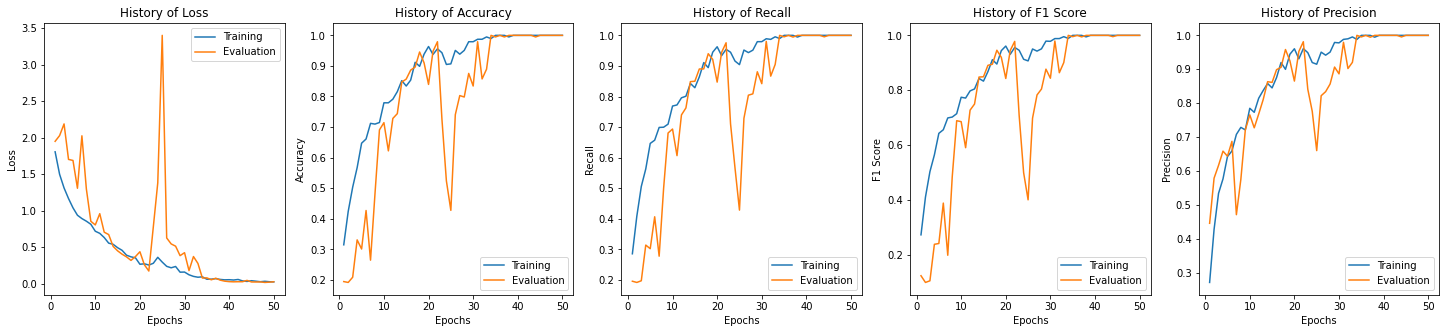

In [43]:
plot_metrics(["Loss", "Accuracy", "Recall", "F1 Score", 'Precision'], history)

In [44]:
loader = DataLoader(test_data, 32, shuffle=True)
resnet: nn.Module = t.load('dummy_Eval_Accuracy.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		y_pred+=(_y.argmax(1).tolist())

accuracy_score(y_true, y_pred)


1.0

In [45]:
loader = DataLoader(test_data, 32, shuffle=True)
resnet: nn.Module = t.load('dummy_Eval_Loss.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		y_pred+=(_y.argmax(1).tolist())
  
accuracy_score(y_true, y_pred)


1.0

In [46]:
augmentator = ImageDataAugmentator(autoconstrast=True, adjust_sharpeness=True,
                                   shear_scale_and_translate=True,
                                   vertical_flip=True, horizontal_flip=True,
                                   options=AugmentatorOptions(angles=(-10, 10), 
                                                              interpolation=InterpolationMode.NEAREST, 
                                                              target_shape=(256,256), 
                                                              translate=(0.2, 0.2), 
                                                              scale=(0.99, 1), 
                                                              sharpness_factor=1.2, 
                                                              shear=(-0.2, 0.2), 
                                                              p_vertical_flip=0.5, 
                                                              p_horizontal_flip=0.5, 
                                                              p_rotate=0.5, 
                                                              p_scale_shear_and_translate=0.5, 
                                                              padding_mode='reflect')).to('cuda')

In [47]:
resnet = ResNet(3, 6, [128, 256, 512], [2, 2, 2], [7, 3, 3, 3], 
                strides=[2,1,2,2], block_types=BasicBlock)
resnet_augmented_raw = nn.Sequential(
    augmentator,
	Lambda(lambda x: x/255),
    resnet
)

In [48]:
dataset = PlantDataset('augmented', train=None, classes_mapping_file="mapping.csv")

In [49]:
train_dataset, test_dataset = split_with_stratification(dataset, ratio=0.9)

In [50]:
history = fit(resnet_augmented_raw, nn.CrossEntropyLoss(), 
              optim.Adam(resnet.parameters(),lr=1e-3), train_dataset,  
              10, batch_size=50, validation_batch_size=50, validation_data=test_dataset, 
              model_to_save=resnet, name="plant_resnet", 
              save_model_on_metrics=["Eval. Loss", "Eval. Accuracy"])

  0%|          | 0/10 [00:00<?, ?it/s]

Improved Eval. Loss to 1.4978363513946533
Improved Eval. Accuracy to 0.5501053333282471
Improved Eval. Loss to 1.4558393955230713
Improved Eval. Accuracy to 0.5737894773483276
Improved Eval. Loss to 0.8165608048439026
Improved Eval. Accuracy to 0.781473696231842
Improved Eval. Loss to 0.23980721831321716
Improved Eval. Accuracy to 0.9110526442527771
Improved Eval. Loss to 0.19071431457996368
Improved Eval. Accuracy to 0.9291577935218811


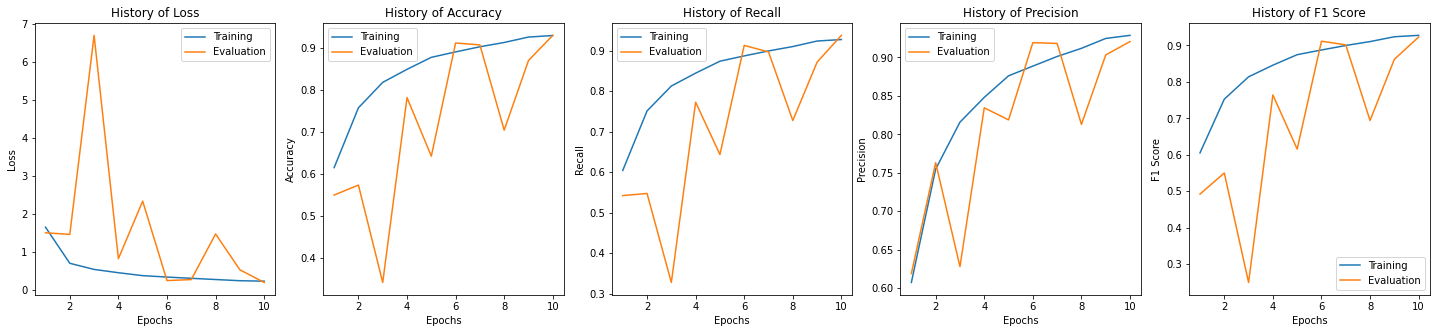

In [51]:
plot_metrics(["Loss", "Accuracy", "Recall", 'Precision', "F1 Score"], history)

# Test on not augmented data

In [52]:
test_data = PlantDataset('dataset', transform=Resize((256,256)), classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 32, shuffle=True)
resnet: nn.Module = t.load('plant_resnet_Eval_Accuracy.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		y_pred+=(_y.argmax(1).tolist())
  
accuracy_score(y_true, y_pred)

loaded


0.9641350210970464

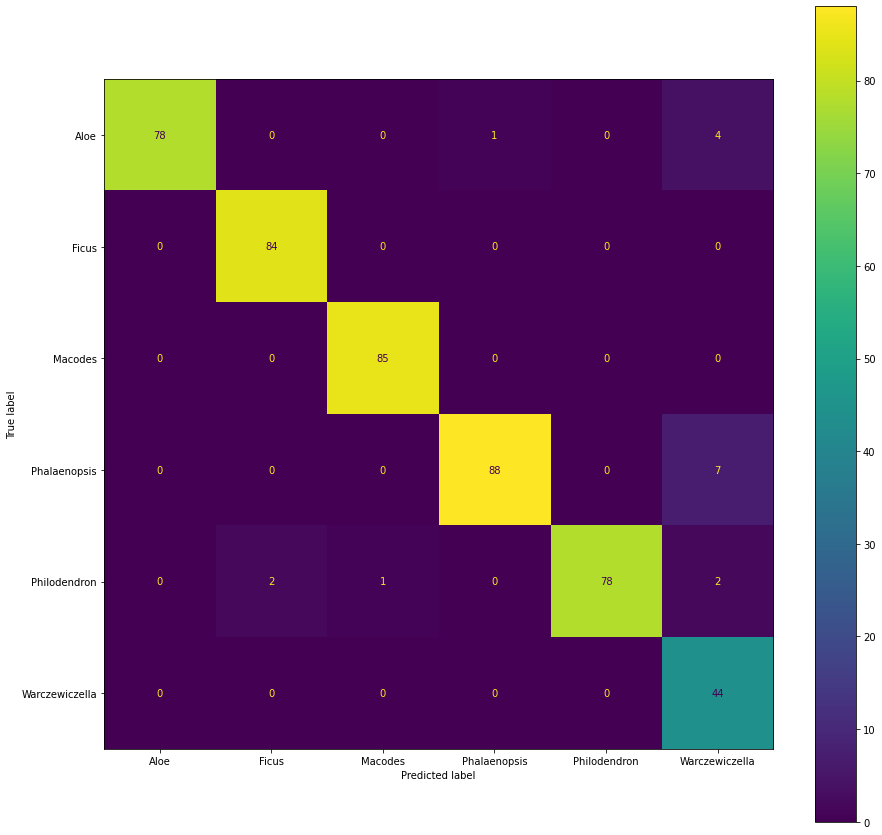

In [53]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, display_labels=test_data.mapping.sort_values(by='Label')['Full Name'].to_list())
disp.plot(ax=ax)

In [54]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data.mapping.sort_values(by='Label')['Full Name'].to_list()))

                precision    recall  f1-score   support

          Aloe       1.00      0.94      0.97        83
         Ficus       0.98      1.00      0.99        84
       Macodes       0.99      1.00      0.99        85
  Phalaenopsis       0.99      0.93      0.96        95
  Philodendron       1.00      0.94      0.97        83
Warczewiczella       0.77      1.00      0.87        44

      accuracy                           0.96       474
     macro avg       0.95      0.97      0.96       474
  weighted avg       0.97      0.96      0.97       474



In [55]:
test_data = PlantDataset('dataset', transform=Resize((256,256)), classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 32, shuffle=True)
resnet: nn.Module = t.load('plant_resnet_Eval_Loss.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		y_pred+=(_y.argmax(1).tolist())
  
accuracy_score(y_true, y_pred)

loaded


0.9641350210970464

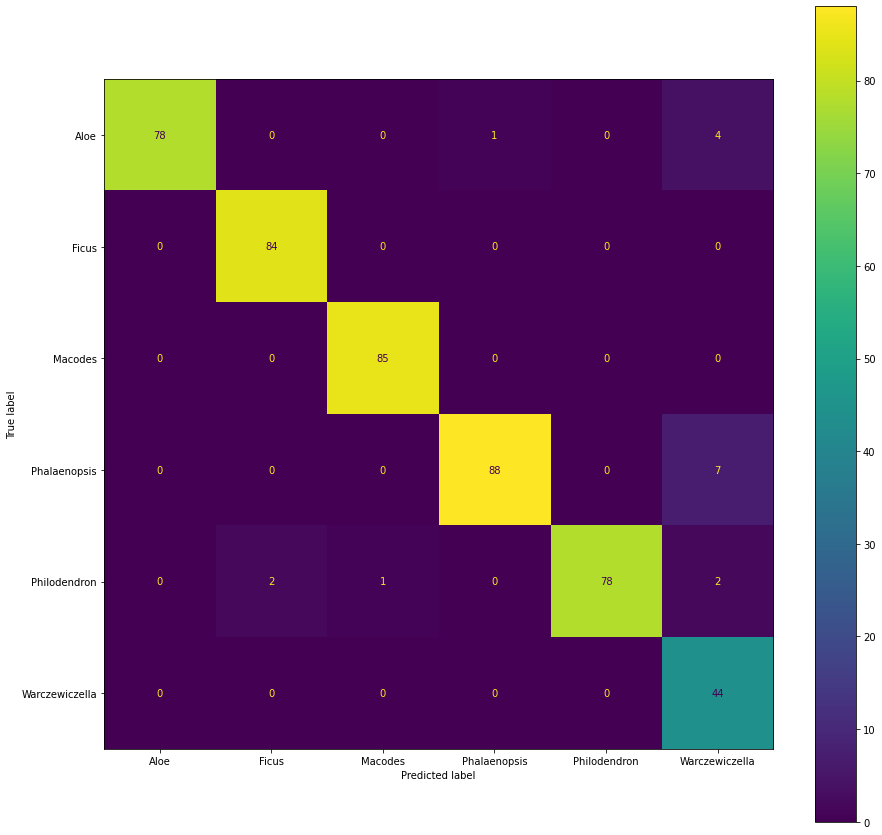

In [56]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, display_labels=test_data.mapping.sort_values(by='Label')['Full Name'].to_list())
disp.plot(ax=ax)

In [57]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data.mapping.sort_values(by='Label')['Full Name'].to_list()))

                precision    recall  f1-score   support

          Aloe       1.00      0.94      0.97        83
         Ficus       0.98      1.00      0.99        84
       Macodes       0.99      1.00      0.99        85
  Phalaenopsis       0.99      0.93      0.96        95
  Philodendron       1.00      0.94      0.97        83
Warczewiczella       0.77      1.00      0.87        44

      accuracy                           0.96       474
     macro avg       0.95      0.97      0.96       474
  weighted avg       0.97      0.96      0.97       474



## Test on my pictures of plants

In [58]:
test_data = PlantDataset('from_camera', transform=Resize((256, 256)), classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 16)
resnet: nn.Module = t.load('plant_resnet_Eval_Accuracy.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		
		y_pred+=(_y.argmax(1).tolist())
  
print(y_true)
print(y_pred)
accuracy_score(y_true, y_pred)


loaded
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]
[5, 0, 0, 3, 1, 3, 3, 3, 3, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 1, 3, 5, 4, 5, 4, 1, 3, 3, 1, 1, 4, 4, 4, 1, 3, 1, 4, 1, 4, 5, 5, 4, 3]


0.5517241379310345

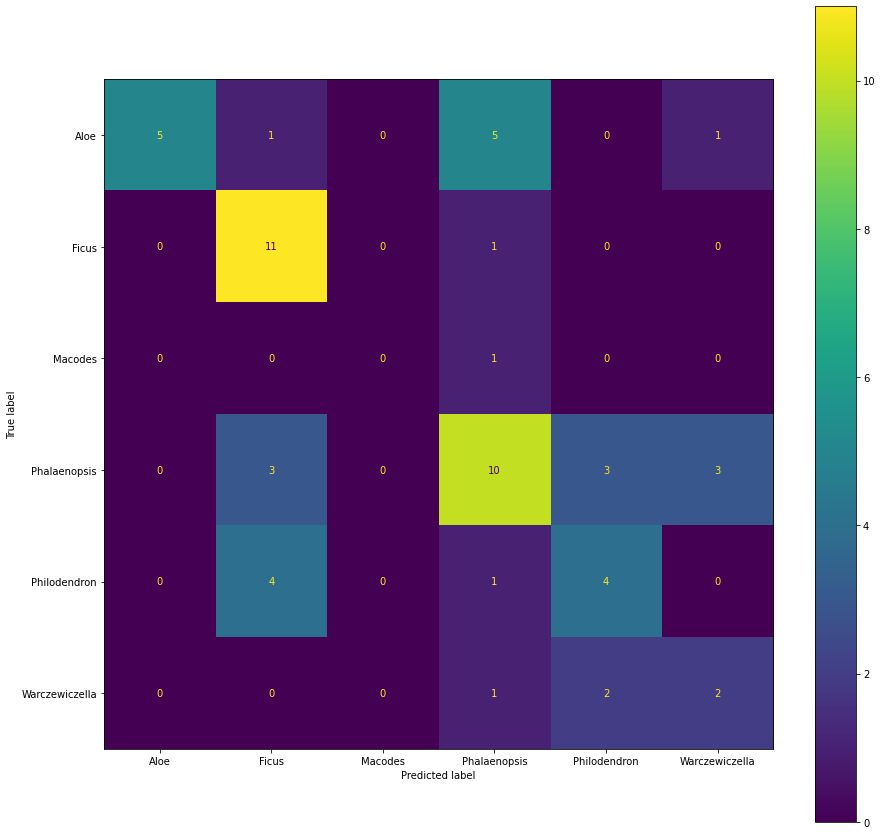

In [59]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, display_labels=test_data.mapping.sort_values(by='Label')['Full Name'].to_list())
disp.plot(ax=ax)

In [60]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data
                            .mapping
                                .sort_values(by='Label')['Full Name']
                                .to_list()))

                precision    recall  f1-score   support

          Aloe       1.00      0.42      0.59        12
         Ficus       0.58      0.92      0.71        12
       Macodes       0.00      0.00      0.00         1
  Phalaenopsis       0.53      0.53      0.53        19
  Philodendron       0.44      0.44      0.44         9
Warczewiczella       0.33      0.40      0.36         5

      accuracy                           0.55        58
     macro avg       0.48      0.45      0.44        58
  weighted avg       0.60      0.55      0.54        58



d:\Projects\GSN1\gsn1_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\GSN1\gsn1_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Projects\GSN1\gsn1_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
test_data = PlantDataset('from_camera', transform=Resize((256, 256)), 
                         classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 16)
resnet: nn.Module = t.load('plant_resnet_Eval_Loss.pth')
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		
		y_pred+=(_y.argmax(1).tolist())
  
print(y_true)
print(y_pred)
accuracy_score(y_true, y_pred)


loaded
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]
[5, 0, 0, 3, 1, 3, 3, 3, 3, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 1, 3, 5, 4, 5, 4, 1, 3, 3, 1, 1, 4, 4, 4, 1, 3, 1, 4, 1, 4, 5, 5, 4, 3]


0.5517241379310345

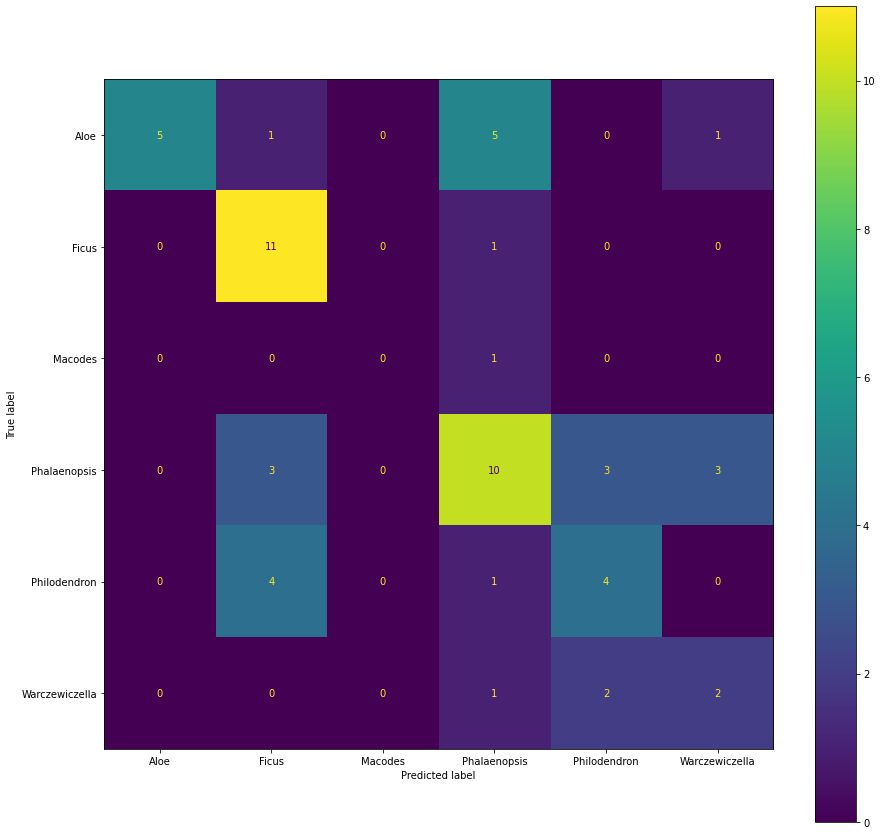

In [78]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, 
                              display_labels=test_data
                                      .mapping
                                          .sort_values(by='Label')['Full Name']
                                          .to_list())
disp.plot(ax=ax)

In [79]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data
                            .mapping
                                .sort_values(by='Label')['Full Name']
                                .to_list(), zero_division=0))

                precision    recall  f1-score   support

          Aloe       1.00      0.42      0.59        12
         Ficus       0.58      0.92      0.71        12
       Macodes       0.00      0.00      0.00         1
  Phalaenopsis       0.53      0.53      0.53        19
  Philodendron       0.44      0.44      0.44         9
Warczewiczella       0.33      0.40      0.36         5

      accuracy                           0.55        58
     macro avg       0.48      0.45      0.44        58
  weighted avg       0.60      0.55      0.54        58



# Using deeper model - a pretrained resnet18

In [61]:
_resnet18 = resnet18(True)
print(_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
my_resnet18 = ResNet(3, 
                     1000, 
                     [64, 128, 256, 512], 
                     [2,2,2,2], 
                     kernels=[7,3,3,3,3], 
                     strides=[2,1,2,2,2], 
                     block_types=BasicBlock)
print(my_resnet18)

ResNet(
  (_encoder): ResNetBaseEncoder(
    (_block): Sequential(
      (0): GateBlock(
        (_block): Sequential(
          (0): Conv2dAutoPad(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2dAutoPad(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=True, x_padding=(0, 1), y_padding=(0, 1))
        )
      )
      (1): ResNetBaseLayer(
        (_block): Sequential(
          (0): BasicBlock(
            (_block): Sequential(
              (0): Conv2dAutoPad(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): Conv2dAutoPad(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [63]:
keys = my_resnet18.state_dict().keys()
values = _resnet18.state_dict().values()
new_dict = OrderedDict({k:v for k,v in zip(keys,values)})
my_resnet18.load_state_dict(new_dict, False)

<All keys matched successfully>

In [64]:
encoder = my_resnet18._encoder
for param in encoder.parameters():
	param.requires_grad = False
 
#for param in _resnet18.parameters(): param.requires_grad = False
decoder = ResNetBaseDecoder(encoder.out_channels, 6)
classifier = nn.Sequential(
	
	nn.Dropout(0.3),
	nn.Flatten(),
	nn.BatchNorm1d(encoder.out_channels *8*8),
	nn.Linear(encoder.out_channels*8*8, 64),
	nn.BatchNorm1d(64),
	Activations.get('relu'),
	nn.Dropout(0.2),
	nn.Linear(64, 32),
	nn.BatchNorm1d(32),
	Activations.get('relu'),
	nn.Linear(32, 6)
)

for m in classifier.modules():
	if isinstance(m, (nn.BatchNorm1d)):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
	elif isinstance(m, nn.Linear):
		nn.init.constant_(m.bias, 0)
		nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

plant_resnet = nn.Sequential(encoder, classifier)

In [65]:
dataset = PlantDataset('augmented', classes_mapping_file='mapping.csv')#, transform=Resize((256,256)))


In [66]:
train_data, test_data = split_with_stratification(dataset, ratio=0.9)

In [67]:
augmentator = ImageDataAugmentator(autoconstrast=True, adjust_sharpeness=True, 
                                   shear_scale_and_translate=True,
                                   vertical_flip=True, horizontal_flip=True,
                                   options=AugmentatorOptions(angles=(-30, 30), 
                                                              interpolation=InterpolationMode.NEAREST,
                                                              target_shape=(256,256), 
                                                              translate=(0.2, 0.2), 
                                                              scale=(0.99, 1), 
                                                              sharpness_factor=1.2, 
                                                              shear=(-0.2, 0.2), 
                                                              p_vertical_flip=0.5, 
                                                              p_horizontal_flip=0.5, 
                                                              p_rotate=0.5, 
                                                              p_scale_shear_and_translate=0.5, 
                                                              padding_mode='reflect')).to('cuda')

In [68]:
resnet_augmented = nn.Sequential(
	augmentator,
	Lambda(lambda x: x/255),
 	plant_resnet
)

In [69]:
history = fit(resnet_augmented,
              nn.CrossEntropyLoss(),
              optim.Adam(classifier.parameters(), lr=1e-2),
              train_data, 
              7, 
              50, 
              validation_batch_size=50,
              validation_data=test_data, 
              model_to_save=classifier, 
              name="plant_classifier", 
              save_model_on_metrics=["Eval. Loss", "Eval. Accuracy"])

  0%|          | 0/7 [00:00<?, ?it/s]

Improved Eval. Loss to 0.5340507626533508
Improved Eval. Accuracy to 0.808368444442749
Improved Eval. Loss to 0.37792906165122986
Improved Eval. Accuracy to 0.8856842517852783
Improved Eval. Loss to 0.29276344180107117
Improved Eval. Accuracy to 0.9143684506416321
Improved Eval. Loss to 0.26840510964393616
Improved Eval. Loss to 0.2534193694591522
Improved Eval. Accuracy to 0.9523157477378845
Improved Eval. Loss to 0.19308330118656158
Improved Eval. Accuracy to 0.953315794467926


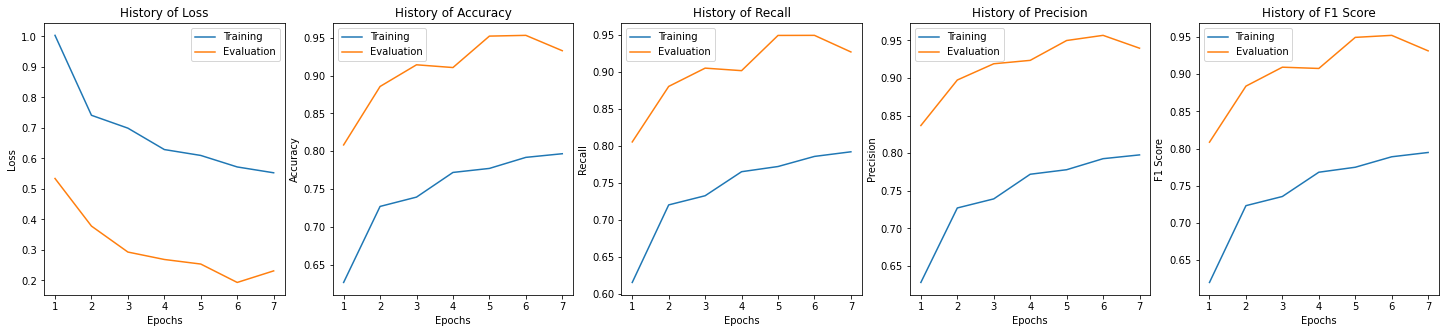

In [70]:
plot_metrics(["Loss", "Accuracy", "Recall", 'Precision', "F1 Score"], history)

## Test on my pictures of plants

In [71]:
test_data = PlantDataset('from_camera', classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 16)
classifier.load_state_dict(t.load('plant_classifier_Eval_Accuracy.pth').state_dict())
resnet: nn.Module = nn.Sequential(Resize((256, 256)), plant_resnet)
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		
		y_pred+=(_y.argmax(1).tolist())
  
print(y_true)
print(y_pred)
accuracy_score(y_true, y_pred)



loaded
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]
[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 0, 3, 0, 3, 4, 3, 3, 3, 1, 0, 4, 0, 4, 0, 1, 1, 3, 1, 0, 3, 5, 0, 0]


0.6551724137931034

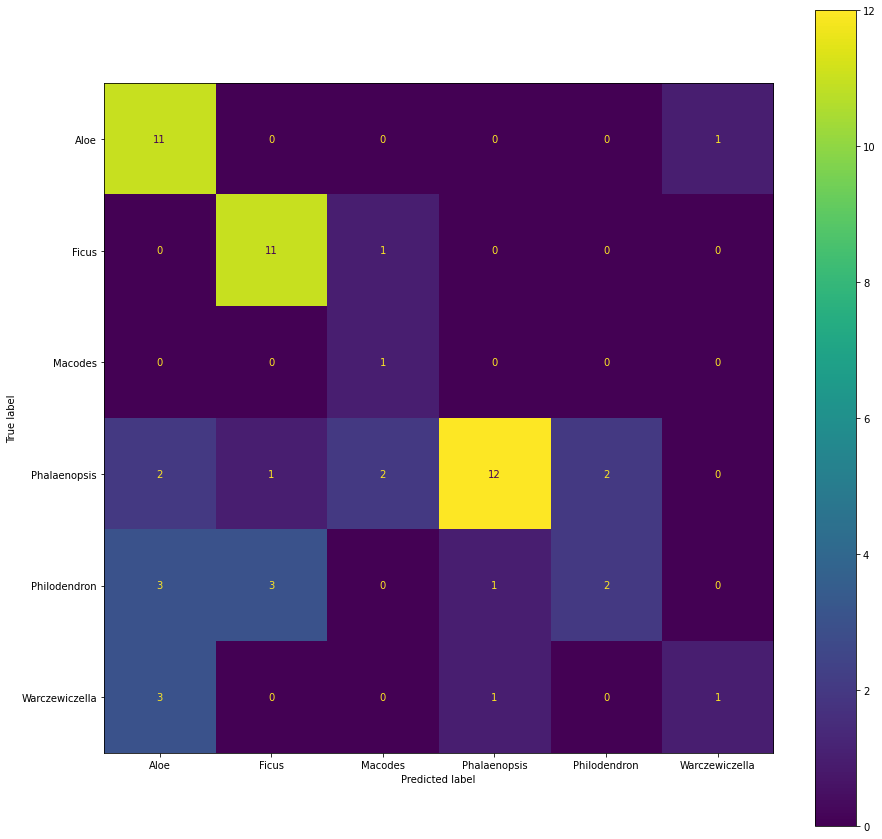

In [72]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, display_labels=test_data
                                      .mapping
                                          .sort_values(by='Label')['Full Name']
                                          .to_list())
disp.plot(ax=ax)

In [73]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data
                            .mapping
                                .sort_values(by='Label')['Full Name']
                                .to_list(), zero_division=0))

                precision    recall  f1-score   support

          Aloe       0.58      0.92      0.71        12
         Ficus       0.73      0.92      0.81        12
       Macodes       0.25      1.00      0.40         1
  Phalaenopsis       0.86      0.63      0.73        19
  Philodendron       0.50      0.22      0.31         9
Warczewiczella       0.50      0.20      0.29         5

      accuracy                           0.66        58
     macro avg       0.57      0.65      0.54        58
  weighted avg       0.68      0.66      0.63        58



In [74]:
test_data = PlantDataset('from_camera', classes_mapping_file='mapping.csv')
loader = DataLoader(test_data, 16)
classifier.load_state_dict(t.load('plant_classifier_Eval_Loss.pth').state_dict())
resnet: nn.Module = nn.Sequential(Resize((256, 256)), plant_resnet)
resnet.eval()
y_true = []
y_pred = []
with t.no_grad():
	for item in loader:
		x: t.Tensor = item[0].cuda()
		y: t.Tensor = item[1]
		count = len(x)
		y_true+=(y.tolist())
		_y: t.Tensor = resnet(x/255)
		
		y_pred+=(_y.argmax(1).tolist())
  

print(y_true)
print(y_pred)
accuracy_score(y_true, y_pred)



loaded
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]
[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 2, 0, 3, 0, 3, 4, 3, 3, 3, 1, 0, 4, 0, 4, 0, 1, 1, 3, 1, 0, 3, 5, 0, 0]


0.6551724137931034

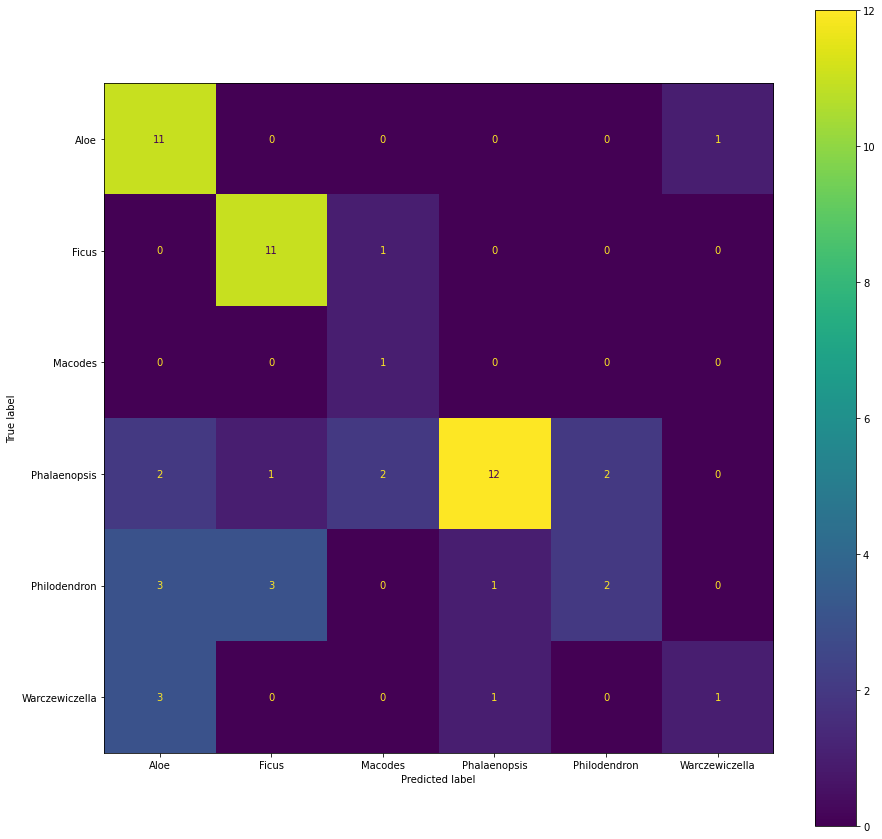

In [75]:
m = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(1,1, figsize=(15, 15))
disp = ConfusionMatrixDisplay(m, display_labels=test_data
                                                  .mapping
                                                      .sort_values(by='Label')['Full Name']
                                                      .to_list())
disp.plot(ax=ax)

In [76]:
print(classification_report(y_true, y_pred, 
                            target_names=test_data
                            .mapping
                                .sort_values(by='Label')['Full Name']
                                .to_list(), zero_division=0))

                precision    recall  f1-score   support

          Aloe       0.58      0.92      0.71        12
         Ficus       0.73      0.92      0.81        12
       Macodes       0.25      1.00      0.40         1
  Phalaenopsis       0.86      0.63      0.73        19
  Philodendron       0.50      0.22      0.31         9
Warczewiczella       0.50      0.20      0.29         5

      accuracy                           0.66        58
     macro avg       0.57      0.65      0.54        58
  weighted avg       0.68      0.66      0.63        58



## Conclusions

- Increasing the model depth and preparing more images could boost the learning performance of models.
- To achieve good results on real examples it could be necessary to provide some samples to basic, not-augmented dataset - the pictures from the Internet - additionally preprocessed manually (background removal, enhancing quality etc.) can differ much from those taken by me in bad light-conditions using a moderate quality camera.